<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/5_Forecasting%20%7C%20Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/Datasets/final_dataset_fs_db.csv', parse_dates=['dates'],  index_col='dates',infer_datetime_format=True)
df.drop(['Unnamed: 0', 'Purity'], axis=1, inplace=True)

In [3]:
from sklearn.preprocessing import MinMaxScaler

# Normalization
values = df[['% Silica Concentrate']].values

# Normalization
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(values)

In [4]:
def create_data(series, prev_instances = 4):
 
    X_train_1 = pd.DataFrame(series).astype('float64')
    X_train_temp = X_train_1.shift(1)
    y_label = X_train_1.shift(-1)
    
    data = pd.concat([X_train_temp, X_train_1, y_label], axis=1)
    
    for r in range(prev_instances-2):
      X_train_temp = X_train_temp.shift(1)
      data = pd.concat([X_train_temp, data], axis=1)
    data.dropna(inplace = True)
    data.reset_index(drop = True, inplace = True)
    # print(data.head(10))
    X = data.iloc[:, 0:-1].values 
    y = data.iloc[:,-1].values 
    
    print('This series takes {} previous instances'.format(prev_instances))
    
    data.columns = [*data.columns[:-1], 'y']
    
    return data, X, y

In [5]:
WINDOW_SIZE = 5

time_series = scaled_data;
data, X, y = create_data(time_series, prev_instances = WINDOW_SIZE)

This series takes 5 previous instances


In [6]:
# 70% 15% 15%

X_train, y_train = X[:3935], y[:3935]
X_test, y_test = X[3935:4775], y[3935:4775]
X_val, y_val = X[4775:], y[4775:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((3935, 5), (3935,), (840, 5), (840,), (841, 5), (841,))

In [7]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], WINDOW_SIZE,1))
X_test = X_test.reshape((X_test.shape[0], WINDOW_SIZE, 1))
X_val = X_val.reshape((X_val.shape[0], WINDOW_SIZE, 1))

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((3935, 5, 1), (3935,), (840, 5, 1), (840,), (841, 5, 1), (841,))

In [8]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  
    mae = np.mean(np.abs(forecast - actual))    
    rmse = np.mean((forecast - actual)**2)**.5  

    return mape, mae, rmse

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install wandb -qqq
import wandb
wandb.login()

In [ ]:
sweep_transformer_config = {
    "method": "random", 
    "metric": {
      "name": "MAPE",
      "goal": "minimize"   
    },
    "parameters": {
        
        "learning_rate": {
            "values": [0.0001, 0.001, 0.005, 0.01]
        },
        "epochs": {
            "values": [100, 150, 200, 300]
        },
        "batch_size": {
            "values": [64, 128]
        },
        "head_size": {
            "values": [128, 256]
        },
        "num_heads": {
            "values": [4, 8, 16]
        },
        "num_transformer_blocks": {
            "values": [4, 8]
        },
        "mlp_units": {
            "values":[64, 128, 256]
        },
        "mlp_dropout": {
            "values": [0.2, 0.25, 0.3]
        },
        "dropout": {
            "values": [0.2, 0.25, 0.3]
        },
        "hidden_dim": {
            "values":[100, 150, 200]
        },
        "positional_ff_dim": {
            "values":[64, 128, 256]
        }
    }
}

sweep_id = wandb.sweep(sweep_transformer_config, project="Transformer_shot_7")

Create sweep with ID: w8cx01b8
Sweep URL: https://wandb.ai/malekkamoua/Transformer_shot_7/sweeps/w8cx01b8


In [ ]:
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense, InputLayer

from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError, MeanAbsolutePercentageError
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# Define early_stopping_monitor
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=10)

from wandb.keras import WandbCallback

def train():
  config_defaults = {
    "learning_rate": 0.001,
    "epochs": 100,
    "batch_size": 128,
    "head_size": 256,
    "num_heads": 4,
    "num_transformer_blocks": 4,
    "mlp_units": 128,
    "mlp_dropout": 0.2,
    "dropout": 0.25,
    "hidden_dim": 100,
    "positional_ff_dim": 128
  }


  wandb.init(config=config_defaults)  # defaults are over-ridden during the sweep
  config = wandb.config

  look_back = 5
  n_features = 1
  horizon = 1

  checkpoint_dir = "checkpoint"

  head_size = wandb.config['head_size']
  num_heads = wandb.config['num_heads']
  num_transformer_blocks = wandb.config['num_transformer_blocks']
  mlp_units = [wandb.config['mlp_units']] 
  mlp_dropout = wandb.config['mlp_dropout']
  dropout = wandb.config['dropout']
  hidden_dim =  wandb.config['hidden_dim']  # Number of neurons in each recurrent unit 
  positional_ff_dim =  wandb.config['positional_ff_dim']

  cp = ModelCheckpoint('model/', save_best_only=True)

  inputs = keras.Input(shape=(look_back, n_features))
  x = inputs

  for _ in range(num_transformer_blocks):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
    key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)

    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=positional_ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = x + res

  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)
  
  outputs = layers.Dense(horizon)(x)
  model = keras.Model(inputs, outputs)
 
  model.compile( loss = MeanSquaredError(), 
                    optimizer = Adam(learning_rate= wandb.config['learning_rate']), 
                    metrics=['mae',
                          MeanSquaredError(),
                          RootMeanSquaredError(),
                          MeanAbsolutePercentageError()])
  
  history = model.fit(X_train, y_train, 
                      epochs = wandb.config['epochs'] , 
                      batch_size = wandb.config['batch_size'],
                      validation_data=(X_test, y_test),
                      callbacks= [early_stopping_monitor, 
                                  WandbCallback()])  
  
  
  y_pred_val = model.predict(np.asarray(X_val).astype('float32'))
  Inverse_y_val = y_val.reshape(-1,1)
  Inverse_y_val = scaler.inverse_transform(Inverse_y_val)
  Inverse_y_pred_val = scaler.inverse_transform(y_pred_val)
 
  mape, mae, rmse = forecast_accuracy(Inverse_y_pred_val, Inverse_y_val)

  wandb.log({"MAPE": mape, "MAE": mae, "RMSE": rmse})

  wandb.finish()  

In [ ]:
wandb.agent(sweep_id, train, count=200) 

In [9]:
from keras.models import load_model
from keras.utils.vis_utils import plot_model

filepath = '/content/gdrive/MyDrive/Datascience/PFE/transformer-best.h5'
best_model = load_model(filepath, compile=False)

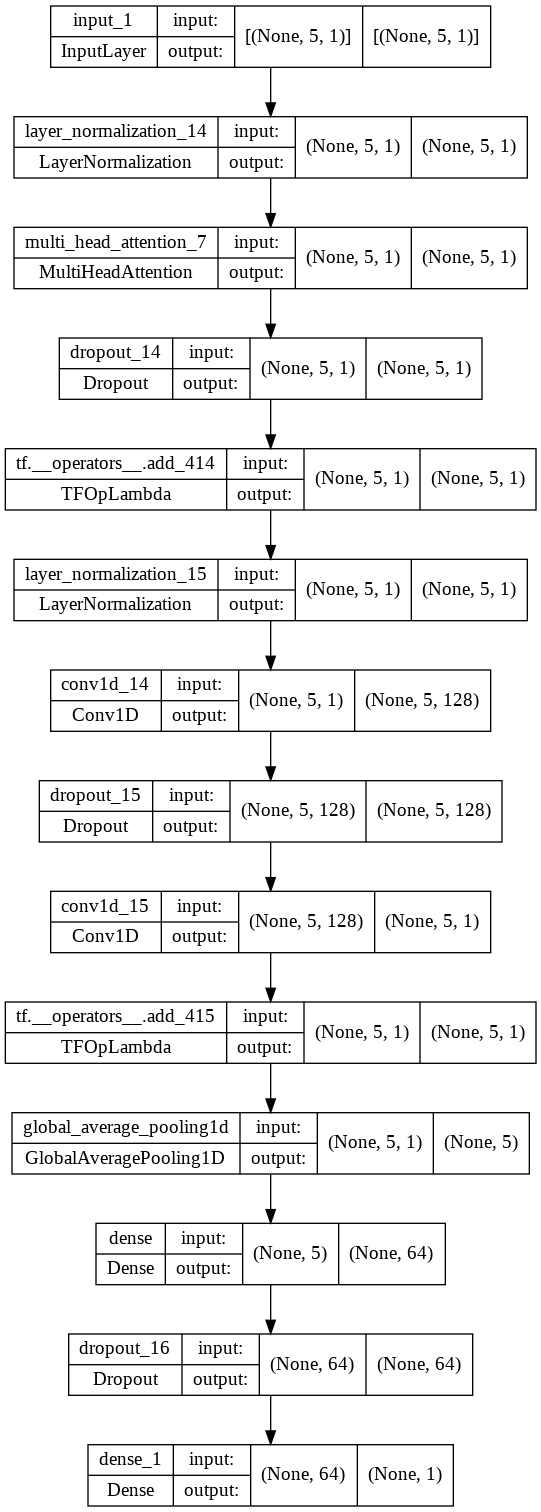

In [10]:
from keras.models import load_model
from keras.utils.vis_utils import plot_model

plot_model(best_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

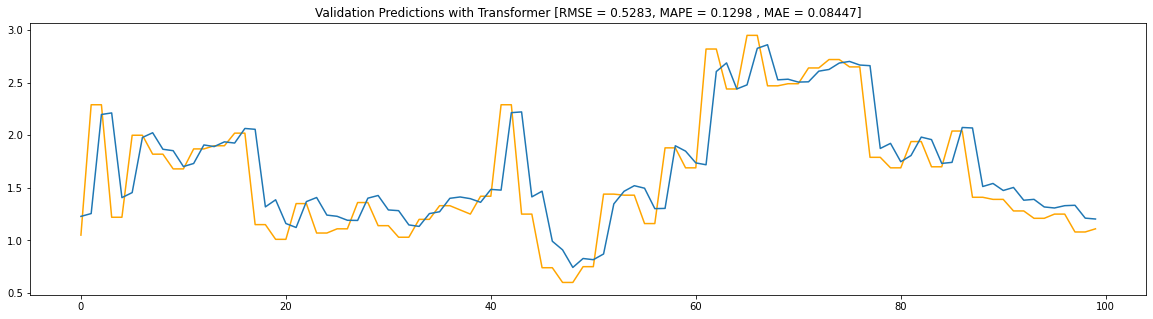

In [15]:
y_pred_val = best_model.predict(np.asarray(X_val).astype('float32'))
Inverse_y_val = y_val.reshape(-1,1)
Inverse_y_val = scaler.inverse_transform(Inverse_y_val)
Inverse_y_pred_val = scaler.inverse_transform(y_pred_val)

mape, mae, rmse = forecast_accuracy(Inverse_y_pred_val, Inverse_y_val)

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(Inverse_y_val[0:100], color='orange')
plt.plot(Inverse_y_pred_val[0:100])


plt.title("Validation Predictions with Transformer [RMSE = 0.5283, MAPE = 0.1298 , MAE = 0.08447]"  )
plt.show()

In [12]:
Inverse_y_pred_val[10].tolist()[0]

1.702244520187378

In [13]:
Inverse_y_val[10].tolist()[0]

1.6800000000000002